In [3]:
from functools import partial
from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, analysis:ignore
from scipy import stats
import numpy as np
import pandas as pd
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import mne
from mne.stats import (
    bonferroni_correction,
    fdr_correction,
    permutation_cluster_1samp_test,
    permutation_t_test, 
    permutation_cluster_test,
    ttest_1samp_no_p)

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm 

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import warnings
warnings.filterwarnings("ignore")

from lib_data import DATA_IO
import utils_spectrogram, utils_plotting, utils_statistics

# 0. DATA I/O

In [5]:
df_spectrogram              = pd.read_pickle(DATA_IO.path_events + "time_frequency_activity/ECOG_TFA") 
df_spectrogram_noLID_noDOPA = df_spectrogram[df_spectrogram.severity=="noLID_noDOPA"]
df_spectrogram_noLID_DOPA   = df_spectrogram[df_spectrogram.severity=="noLID_DOPA"]
df_spectrogram_LID          = df_spectrogram[df_spectrogram.severity=="LID"]

# filtering for stable estimation of LME coefficients
df_spectrogram_noLID_noDOPA = df_spectrogram_noLID_noDOPA[df_spectrogram_noLID_noDOPA.patient.isin(df_spectrogram_noLID_noDOPA.patient.value_counts()[lambda x: x >= 5].index)]
df_spectrogram_noLID_DOPA   = df_spectrogram_noLID_DOPA[df_spectrogram_noLID_DOPA.patient.isin(df_spectrogram_noLID_DOPA.patient.value_counts()[lambda x: x >= 5].index)]
df_spectrogram_LID          = df_spectrogram_LID[df_spectrogram_LID.patient.isin(df_spectrogram_LID.patient.value_counts()[lambda x: x >= 5].index)]

# 1. LME

## 1.1 Train Models

In [8]:
def point_wise_LME_spectrogram_between_severity(dataframe, feature_spectrogram, n_downsampling):
    
    X          = np.array(dataframe[feature_spectrogram].to_list())
    X          = X.squeeze(axis=1)
    not_nan_i  = ~np.isnan(X).any(axis=(1, 2))
    X          = X[not_nan_i]

    # get patients and spectrogram data
    data       = np.array(X)
    data       = utils_spectrogram.downsample_time_axis_for_spectrogram(data, target_time_points=n_downsampling)
    patients   = np.array(dataframe.patient.to_list())[not_nan_i]
    severity   = np.array(dataframe.severity.to_list())[not_nan_i]

    # Store p-values
    n_subjects = data.shape[0]
    n_freq     = data.shape[1]
    n_time     = data.shape[2]
    p_values   = np.zeros((n_freq, n_time))
    z_scores   = np.zeros((n_freq, n_time)) 
    
    for f_i in range(n_freq):
        for t_i in range(n_time):
            
            y  = data[:, f_i, t_i] # get all the points for the corresponding frequency x timepoint combination
            df = pd.DataFrame({'voxel': y, 'patient': patients,'severity': severity})
            
            try:
                # Fit LME
                model              = mixedlm("voxel ~ severity", df, groups=df["patient"])
                result             = model.fit(reml=False)
                p_values[f_i, t_i] = result.pvalues['severity'] 
                z_scores[f_i, t_i] = result.tvalues['severity']
            except Exception as e:
                p_values[f_i, t_i] = 1
                z_scores[f_i, t_i] = 0
    
        print(str(90-(f_i)) + " Hz is completed...")

    # just in case any p value is np.nan
    p_values[np.isnan(p_values)] = 1

    return p_values, z_scores

### 1.1.1. NoLID-NoDOPA vs LID

In [12]:
# df_comparison_noLIDnoDOPA_vs_LID           = pd.concat([df_spectrogram_noLID_noDOPA, df_spectrogram_LID])
# df_comparison_noLIDnoDOPA_vs_LID.severity  = df_comparison_noLIDnoDOPA_vs_LID.severity.map({'noLID_noDOPA': 0, 'LID': 1})
# df_comparison_noLIDnoDOPA_vs_LID.reset_index(drop=True, inplace=True)
# 
# p_noLIDnoDOPA_vs_LID, z_noLIDnoDOPA_vs_LID = utils_statistics.point_wise_LME_spectrogram_between_severity(df_comparison_noLIDnoDOPA_vs_LID,
#                                                                                                           feature_spectrogram="offset_aligned_normalized",
#                                                                                                           n_downsampling=50)
# np.save(DATA_IO.path_events + "time_frequency_activity/ECOG_p_noLIDnoDOPA_vs_LID", p_noLIDnoDOPA_vs_LID)
# np.save(DATA_IO.path_events + "time_frequency_activity/ECOG_z_noLIDnoDOPA_vs_LID", z_noLIDnoDOPA_vs_LID)

### 1.1.2. NoLID-NoDOPA vs NoLID-DOPA

In [15]:
df_comparison_noLIDnoDOPA_vs_noLIDDOPA          = pd.concat([df_spectrogram_noLID_noDOPA, df_spectrogram_noLID_DOPA])
df_comparison_noLIDnoDOPA_vs_noLIDDOPA.severity = df_comparison_noLIDnoDOPA_vs_noLIDDOPA.severity.map({'noLID_noDOPA': 0, 'noLID_DOPA': 1})
df_comparison_noLIDnoDOPA_vs_noLIDDOPA.reset_index(drop=True, inplace=True)

p_noLIDnoDOPA_vs_noLIDDOPA, z_noLIDnoDOPA_vs_noLIDDOPA = point_wise_LME_spectrogram_between_severity(df_comparison_noLIDnoDOPA_vs_noLIDDOPA,
                                                                                                     feature_spectrogram="offset_aligned_normalized",
                                                                                                     n_downsampling=50)
np.save(DATA_IO.path_events + "time_frequency_activity/ECOG_p_noLIDnoDOPA_vs_noLIDDOPA", p_noLIDnoDOPA_vs_noLIDDOPA)
np.save(DATA_IO.path_events + "time_frequency_activity/ECOG_z_noLIDnoDOPA_vs_noLIDDOPA", z_noLIDnoDOPA_vs_noLIDDOPA)

90 Hz is completed...
89 Hz is completed...
88 Hz is completed...
87 Hz is completed...
86 Hz is completed...
85 Hz is completed...
84 Hz is completed...
83 Hz is completed...
82 Hz is completed...
81 Hz is completed...
80 Hz is completed...
79 Hz is completed...
78 Hz is completed...
77 Hz is completed...
76 Hz is completed...
75 Hz is completed...
74 Hz is completed...
73 Hz is completed...
72 Hz is completed...
71 Hz is completed...
70 Hz is completed...
69 Hz is completed...
68 Hz is completed...
67 Hz is completed...
66 Hz is completed...
65 Hz is completed...
64 Hz is completed...
63 Hz is completed...
62 Hz is completed...
61 Hz is completed...
60 Hz is completed...
59 Hz is completed...
58 Hz is completed...
57 Hz is completed...
56 Hz is completed...
55 Hz is completed...
54 Hz is completed...
53 Hz is completed...
52 Hz is completed...
51 Hz is completed...
50 Hz is completed...
49 Hz is completed...
48 Hz is completed...
47 Hz is completed...
46 Hz is completed...
45 Hz is c

### 1.1.3. NoLID-DOPA vs LID

In [17]:
df_comparison_noLIDDOPA_vs_LID              = pd.concat([df_spectrogram_noLID_DOPA, df_spectrogram_LID])
df_comparison_noLIDDOPA_vs_LID.severity     = df_comparison_noLIDDOPA_vs_LID.severity.map({'noLID_DOPA': 0, 'LID': 1})
df_comparison_noLIDDOPA_vs_LID.reset_index(drop=True, inplace=True)

p_noLIDDOPA_vs_LID, z_noLIDDOPA_vs_LID      = point_wise_LME_spectrogram_between_severity(df_comparison_noLIDDOPA_vs_LID,
                                                                                          feature_spectrogram="offset_aligned_normalized",
                                                                                          n_downsampling=50)
np.save(DATA_IO.path_events + "time_frequency_activity/ECOG_p_noLIDDOPA_vs_LID", p_noLIDDOPA_vs_LID)
np.save(DATA_IO.path_events + "time_frequency_activity/ECOG_z_noLIDDOPA_vs_LID", z_noLIDDOPA_vs_LID)

90 Hz is completed...
89 Hz is completed...
88 Hz is completed...
87 Hz is completed...
86 Hz is completed...
85 Hz is completed...
84 Hz is completed...
83 Hz is completed...
82 Hz is completed...
81 Hz is completed...
80 Hz is completed...
79 Hz is completed...
78 Hz is completed...
77 Hz is completed...
76 Hz is completed...
75 Hz is completed...
74 Hz is completed...
73 Hz is completed...
72 Hz is completed...
71 Hz is completed...
70 Hz is completed...
69 Hz is completed...
68 Hz is completed...
67 Hz is completed...
66 Hz is completed...
65 Hz is completed...
64 Hz is completed...
63 Hz is completed...
62 Hz is completed...
61 Hz is completed...
60 Hz is completed...
59 Hz is completed...
58 Hz is completed...
57 Hz is completed...
56 Hz is completed...
55 Hz is completed...
54 Hz is completed...
53 Hz is completed...
52 Hz is completed...
51 Hz is completed...
50 Hz is completed...
49 Hz is completed...
48 Hz is completed...
47 Hz is completed...
46 Hz is completed...
45 Hz is c

## 1.2 Load Results

In [19]:
p_noLIDnoDOPA_vs_noLIDDOPA = np.load(DATA_IO.path_events + "time_frequency_activity/ECOG_p_noLIDnoDOPA_vs_noLIDDOPA.npy")
z_noLIDnoDOPA_vs_noLIDDOPA = np.load(DATA_IO.path_events + "time_frequency_activity/ECOG_z_noLIDnoDOPA_vs_noLIDDOPA.npy")
# p_noLIDnoDOPA_vs_LID       = np.load(DATA_IO.path_events + "time_frequency_activity/ECOG_p_noLIDnoDOPA_vs_LID.npy")
# z_noLIDnoDOPA_vs_LID       = np.load(DATA_IO.path_events + "time_frequency_activity/ECOG_z_noLIDnoDOPA_vs_LID.npy")
p_noLIDDOPA_vs_LID         = np.load(DATA_IO.path_events + "time_frequency_activity/ECOG_p_noLIDDOPA_vs_LID.npy")
z_noLIDDOPA_vs_LID         = np.load(DATA_IO.path_events + "time_frequency_activity/ECOG_z_noLIDDOPA_vs_LID.npy")

In [20]:
# MULTIPLE COMPARISON CORRECTION

# NoLID-noDOPA vs LID
# eliminating the frequency range between 35-60 Hz
# p_noLIDnoDOPA_vs_LID[30:55,:]       = 1
# z_noLIDnoDOPA_vs_LID[30:55,:]       = 0
# p_noLIDnoDOPA_vs_LID                = fdr_correction(p_noLIDnoDOPA_vs_LID)[1]

# NoLID-noDOPA vs noLID-DOPA
# eliminating the frequency range between 35-60 Hz
p_noLIDnoDOPA_vs_noLIDDOPA[30:55,:] = 1
z_noLIDnoDOPA_vs_noLIDDOPA[30:55,:] = 0
p_noLIDnoDOPA_vs_noLIDDOPA          = fdr_correction(p_noLIDnoDOPA_vs_noLIDDOPA)[1]

# NoLID-DOPA vs LID
# eliminating the frequency range between 35-60 Hz
p_noLIDDOPA_vs_LID[30:55,:]         = 1
z_noLIDDOPA_vs_LID[30:55,:]         = 0
p_noLIDDOPA_vs_LID                  = fdr_correction(p_noLIDDOPA_vs_LID)[1]

In [21]:
from scipy.ndimage import label, sum as ndi_sum

def plot_spectrogram_significance_with_pointwise_LME(p_values, z_scores, threshold, group, cmap, axis, fig=None, min_cluster_size=5):
    
    # time and frequency axes
    time_vector = np.linspace(start=-2, stop=2, num=p_values.shape[1])

    freq_changed = []
    for x in np.arange(4, 91):
        if (x >= 35) and (x < 60):
            freq_changed.append(35 + ((x - 35) / 2.5))
        elif x >= 60:
            freq_changed.append(x - 15)
        else:
            freq_changed.append(x)
    freq_changed = np.array(freq_changed)

    # plot z-scores with fixed color range
    mesh = axis.pcolormesh(time_vector, freq_changed, z_scores, shading='gouraud',
                           cmap=cmap, rasterized=True, vmin=-5, vmax=5)

    # create significance mask
    significance_mask = p_values <= threshold

    # label connected components and filter small clusters
    structure                   = np.ones((3, 3), dtype=int)  # 8-connectivity
    labeled_array, num_features = label(significance_mask, structure=structure)
    sizes                       = ndi_sum(significance_mask, labeled_array, index=np.arange(1, num_features + 1))
    filtered_mask               = np.zeros_like(significance_mask)

    for i, size in enumerate(sizes):
        if size >= min_cluster_size:
            filtered_mask[labeled_array == (i + 1)] = 1

    # overlay colored contours for significant areas
    for region_id in range(1, num_features + 1):
        region_mask = (labeled_array == region_id)

        if np.sum(region_mask) < min_cluster_size:
            continue  # Skip small clusters

        mean_z = np.mean(z_scores[region_mask])
        color = 'navy' if mean_z < 0 else 'crimson'

        # create binary mask for this region only
        region_display = np.zeros_like(filtered_mask)
        region_display[region_mask] = 1

        axis.contour(time_vector, freq_changed, region_display,
                     levels=[0.5], colors=color, linewidths=1)

    # axis ticks and labels
    axis.set_xticks([-2, -1, 0, 1, 2])
    axis.set_xticklabels([-2, -1, 0, 1, 2], fontsize=utils_plotting.LABEL_SIZE)
    axis.set_yticks([4, 12, 20, 35, 45, 55, 65, 75])
    axis.set_yticklabels([4, 12, 20, 35, 60, 70, 80, 90], fontsize=utils_plotting.LABEL_SIZE)
    axis.set_title(group, fontsize=utils_plotting.LABEL_SIZE_title)

    # clean up spines and ticks
    for spine in axis.spines.values():
        spine.set_visible(False)
    axis.xaxis.set_ticks_position('none')
    axis.yaxis.set_ticks_position('none')

    # add colorbar if figure is provided
    if fig is not None:
        cbar = fig.colorbar(mesh, ax=axis, pad=0.02, aspect=20)
        cbar.set_label('Z-score', fontsize=utils_plotting.LABEL_SIZE)
        cbar.ax.tick_params(labelsize=utils_plotting.LABEL_SIZE)

    return axis


<Figure size 640x480 with 0 Axes>

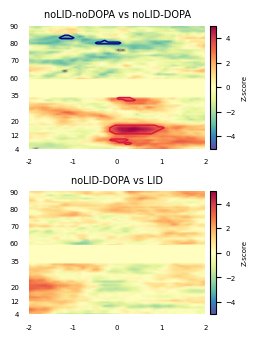

In [22]:
# plot
plt = utils_plotting.get_figure_template()

ax1 = plt.subplot2grid((77, 66), (0, 0) , colspan=25, rowspan=15)
ax2 = plt.subplot2grid((77, 66), (20, 0), colspan=25, rowspan=15)

ax1 = plot_spectrogram_significance_with_pointwise_LME(p_values=p_noLIDnoDOPA_vs_noLIDDOPA, z_scores=z_noLIDnoDOPA_vs_noLIDDOPA, threshold=0.05, 
                                                       group="noLID-noDOPA vs noLID-DOPA", cmap="Spectral_r", axis=ax1, fig=plt)

ax2 = plot_spectrogram_significance_with_pointwise_LME(p_values=p_noLIDDOPA_vs_LID, z_scores=z_noLIDDOPA_vs_LID, threshold=0.05, 
                                                       group="noLID-DOPA vs LID", cmap="Spectral_r", axis=ax2, fig=plt)

plt.savefig(DATA_IO.path_figure + "spectrogram/cortex_spectrogram_offset_pixelwise_differences_between_severity.svg", dpi=1200)